In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
url = '/content/drive/MyDrive/Assignment 2/'

In [4]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [5]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [6]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [7]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [11]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


# **Base Parameters**

In [12]:
batch_size = 30
num_iters = 20000
input_dim = 28*28
num_hidden = 220
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

24


In [18]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:648
Test dataloader:162


In [19]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 =nn.ReLU()

 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        # self.linear_5= nn.Linear(num_hidden, num_hidden)
        # self.relu_5=nn.ReLU()

 
        # self.linear_6 = nn.Linear(num_hidden, num_hidden)
        # self.relu_6 =nn.ReLU()

 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        # out  = self.linear_5(out)
        # out = self.relu_5(out)
 
        # out  = self.linear_6(out)
        # out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [20]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=180, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=180, out_features=180, bias=True)
  (relu_2): Softmax(dim=0)
  (linear_3): Linear(in_features=180, out_features=180, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=180, out_features=180, bias=True)
  (relu_4): ReLU()
  (linear_out): Linear(in_features=180, out_features=10, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [22]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 1.9990379810333252. Accuracy: 35.37764972216505
Epoch:  2
Iteration: 1000. Loss: 1.555175542831421. Accuracy: 44.35068944227207
Epoch:  3
Iteration: 1500. Loss: 1.1968433856964111. Accuracy: 49.47520065857172
Epoch:  4
Iteration: 2000. Loss: 0.9908961653709412. Accuracy: 53.38547026137065
Iteration: 2500. Loss: 0.7750394344329834. Accuracy: 56.30788228030459
Epoch:  5
Iteration: 3000. Loss: 1.193328857421875. Accuracy: 57.316320230500104
Epoch:  6
Iteration: 3500. Loss: 0.9116450548171997. Accuracy: 63.40810866433422
Epoch:  7
Iteration: 4000. Loss: 0.9305989742279053. Accuracy: 65.75427042601358
Iteration: 4500. Loss: 0.6988781094551086. Accuracy: 65.7748507923441
Epoch:  8
Iteration: 5000. Loss: 1.4985432624816895. Accuracy: 69.29409343486314
Epoch:  9
Iteration: 5500. Loss: 0.8825498819351196. Accuracy: 70.17904918707553
Epoch:  10
Iteration: 6000. Loss: 1.1884827613830566. Accuracy: 70.91994237497427
Epoch:  11
Iteration: 6500. Loss: 1.01312422752380

In [23]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Assignment 2/second_attempt.pkl')

[1.9990379810333252, 1.555175542831421, 1.1968433856964111, 0.9908961653709412, 0.7750394344329834, 1.193328857421875, 0.9116450548171997, 0.9305989742279053, 0.6988781094551086, 1.4985432624816895, 0.8825498819351196, 1.1884827613830566, 1.0131242275238037, 0.724735677242279, 0.7170463800430298, 0.3959033787250519, 0.7621675729751587, 0.6110284328460693, 0.8163028955459595, 0.4711258113384247, 0.6224063634872437, 0.40777984261512756, 0.524661123752594, 0.6882681250572205, 0.5033357739448547, 0.44082456827163696, 0.3584180474281311, 0.35436931252479553, 0.46641939878463745, 0.38003018498420715, 0.5088447332382202]


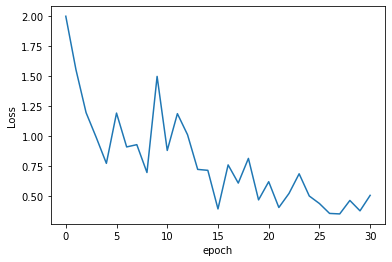

In [25]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()